In [1]:
# import the required packages 

import itertools
import numpy as np
import pandas as pd
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from collections import defaultdict

import pickle

## OBJECTIEVE 1: Identify the Popular Film Genres in the industry
   What is the most watched genre? 

   Which genre is most porpular?
   
   Which genre is most voted for? 

### EDA 

In [11]:
# upload the data
gross_data = pd.read_csv("cleaned_gross_budget.csv")
merged_data = pd.read_csv("cleaned_merged_data.csv")
merged_data.head(2)

,original_language,original_title,popularity,release_date,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788,146.0,"Adventure,Fantasy,Mystery",7.7,425530
1,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610,98.0,"Action,Adventure,Animation",8.1,611299


In [24]:
# Create an empty list to store individual genres
genres_list = []

# Split genres in each row and add them directly to genres_list
for genres in merged_data["genres"]:
    genres_list.extend(genres.split(','))

# Count the number of films by genre
genres_sum = Counter(genres_list)

# Calculate the total number of genre entries for percentage calculation
total_genres = sum(genres_sum.values())

# Create a DataFrame from the Counter, including percentage calculation
genre_df = pd.DataFrame(genres_sum.items(), columns=["Genre", "Count"])
genre_df["Percentage"] = (genre_df["Count"] / total_genres) * 100

# Sort the DataFrame by 'Count' in descending order
genre_df = genre_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Display the table
print(genre_df.head(5))
print(" ")
print("The Top five top watched movies are Drama, Comedy, Documentary, Thriller and Horror")


         Genre  Count  Percentage
0        Drama   7252   21.745127
1       Comedy   3799   11.391304
2  Documentary   3142    9.421289
3     Thriller   3106    9.313343
4       Horror   2977    8.926537
 
The Top five top watched movies are Drama, Comedy, Documentary, Thriller and Horror


In [25]:
# Sample structure for merged_data: A DataFrame containing "genres" and "popularity" columns
# merged_data = pd.DataFrame({'genres': [...], 'popularity': [...]})

# Create a dictionary to store popularity totals and counts by genre
genre_popularity = defaultdict(lambda: {'total_popularity': 0, 'count': 0})

# Iterate through each row in the dataset
for index, row in merged_data.iterrows():
    genres = row["genres"].split(',')
    popularity = row["popularity"]
    for genre in genres:
        genre_popularity[genre]['total_popularity'] += popularity
        genre_popularity[genre]['count'] += 1

# Calculate average popularity for each genre
average_popularity = {genre: data['total_popularity'] / data['count'] for genre, data in genre_popularity.items()}

# Convert the average popularity dictionary to a DataFrame for easy plotting
genre_popularity_df = pd.DataFrame(list(average_popularity.items()), columns=["Genre", "Average Popularity"])

# Sort the DataFrame by "Average Popularity" in descending order
genre_popularity_df = genre_popularity_df.sort_values(by="Average Popularity", ascending=False)
print(genre_popularity_df.head(5))

print(" ")
print("The most porpular genre are Adventure, Animation, Action, Fantansy and Crime")



        Genre  Average Popularity
0   Adventure            8.215844
4   Animation            7.729220
3      Action            6.996766
1     Fantasy            6.559962
10      Crime            5.545509
 
The most porpular genre are Adventure, Animation, Action, Fantansy and Crime


<Axes: xlabel='averagerating'>

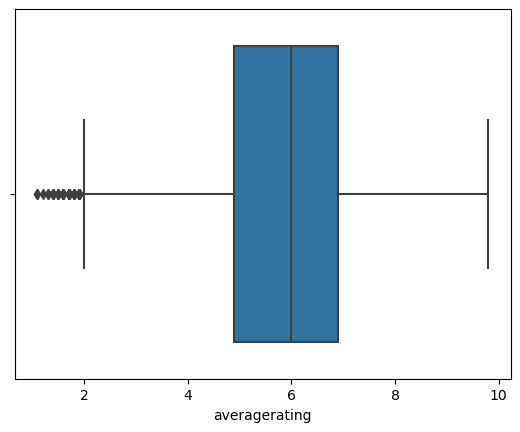

In [5]:
# checking for outliers using sns library and box plot
sns.boxplot(x =merged_data['averagerating'])

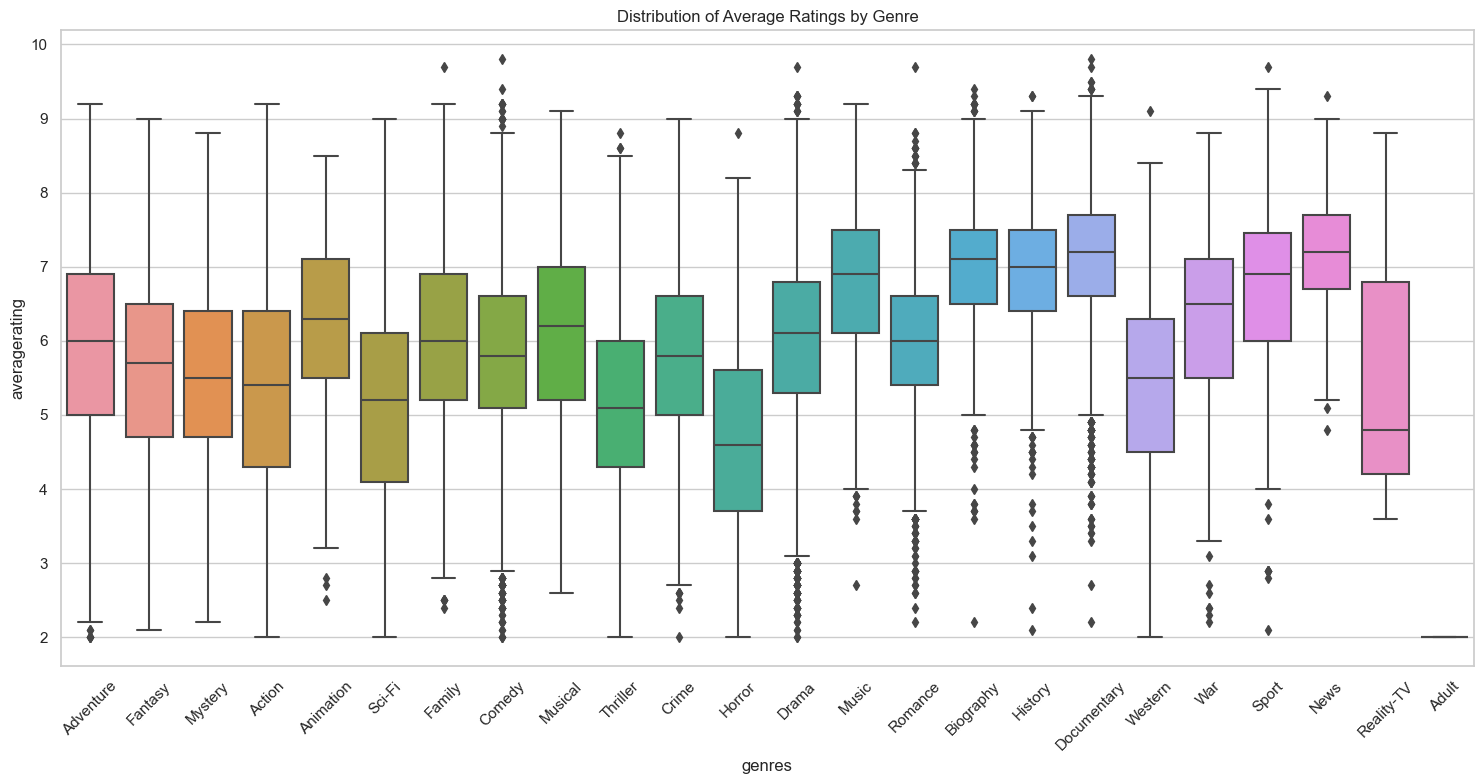

 
The Adventure genre has a median rating of around 6.
Fantasy has a median rating of about 5.5, which is slightly lower than Adventure.
Mystery has a median rating close to 6, similar to Adventure but with a tighter IQR


In [26]:
# To remove outlier 
# We will use the interquatile range to calculate and filter out outliers
# Calculate the IQR
Q1 = merged_data['averagerating'].quantile(0.25)
Q3 = merged_data['averagerating'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
merged_data1 = merged_data[(merged_data['averagerating'] >= lower_bound) & (merged_data['averagerating'] <= upper_bound)]

# checking for outliers using sns library and box plot
# sns.boxplot(x =merged_data1['averagerating'])

# Split genres and explode to analyze each genre separately
df_exploded = merged_data1.assign(genres=merged_data1['genres'].str.split(',')).explode('genres')


# Create plots for averagerating distribution by genre
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_exploded, x='genres', y='averagerating')
plt.xticks(rotation=45)
plt.title('Distribution of Average Ratings by Genre')
plt.tight_layout()
plt.show()

print(" ")
print("The Adventure genre has a median rating of around 6.")
print("Fantasy has a median rating of about 5.5, which is slightly lower than Adventure.")
print("Mystery has a median rating close to 6, similar to Adventure but with a tighter IQR")


### Statistical Distribution

In [8]:
# Display summary statistics to understand the distribution of numerical columns
print(merged_data.describe())

         popularity  vote_average    vote_count  runtime_minutes  \
count  16402.000000  16402.000000  16402.000000     16402.000000   
mean       3.888187      5.731478    283.187050        93.605597   
std        5.008357      1.718946   1151.691744        18.710496   
min        0.600000      0.000000      1.000000         3.000000   
25%        0.665000      4.900000      2.000000        84.000000   
50%        1.787000      5.900000      8.000000        91.000000   
75%        5.774750      6.800000     55.000000       101.000000   
max       80.773000     10.000000  22186.000000       724.000000   

       averagerating      numvotes  
count   16402.000000  1.640200e+04  
mean        5.848488  1.496057e+04  
std         1.407888  6.320184e+04  
min         1.100000  5.000000e+00  
25%         4.900000  9.700000e+01  
50%         6.000000  4.220000e+02  
75%         6.900000  2.889250e+03  
max         9.800000  1.841066e+06  


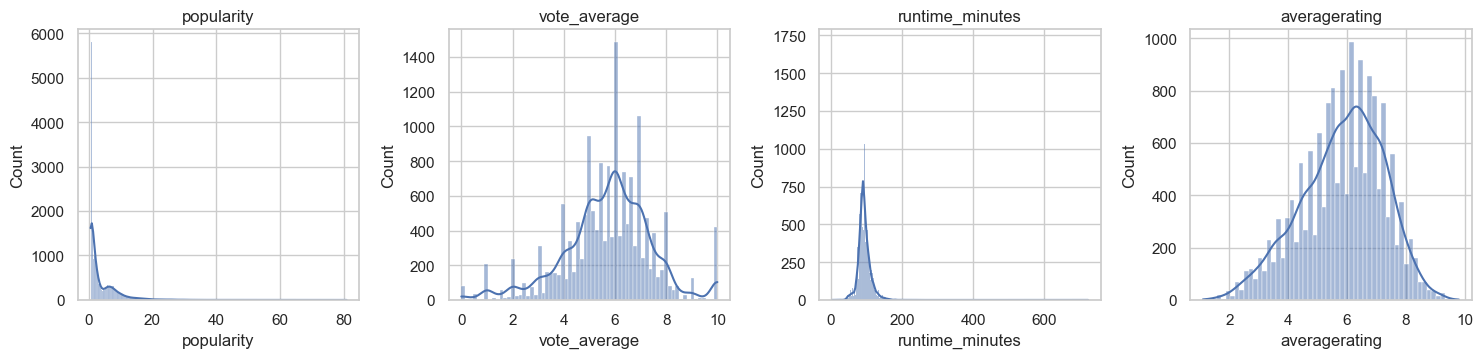

In [9]:
# Set the style of seaborn
sns.set(style='whitegrid')

# Plot histograms for each numerical column
numerical_columns = ['popularity', 'vote_average', 'runtime_minutes', 'averagerating']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(merged_data[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

<Axes: xlabel='production_budget'>

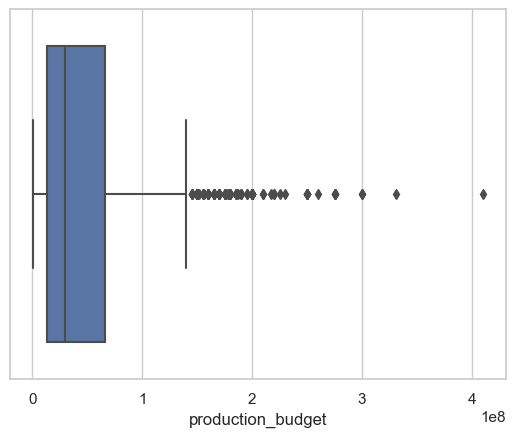

In [19]:
# checking for outliers using sns library and box plot
sns.boxplot(x =gross_data['production_budget'])

In [36]:
# We will use the interquatile range to calculate and filter out outliers
# Calculate the IQR
Q1 = gross_data['production_budget'].quantile(0.25)
Q3 = gross_data['production_budget'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
gross_data1 = gross_data[(gross_data['production_budget'] >= lower_bound) & (gross_data['production_budget'] <= upper_bound)]

# We will use the interquatile range to calculate and filter out outliers
# Calculate the IQR
Q1 = gross_data['domestic_gross'].quantile(0.25)
Q3 = gross_data['domestic_gross'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
gross_data2 = gross_data1[(gross_data1['domestic_gross'] >= lower_bound) & (gross_data1['domestic_gross'] <= upper_bound)]




In [54]:
# 1. Z-test: Compare if the mean production budget differs significantly from $150M
population_mean = 150000000
z_stat, p_value = stats.zscore(gross_data1['production_budget']), stats.norm.sf(abs(stats.zscore(gross_data1['production_budget'])))*2
print ("Z TEST")
print("Z-test for production budget:")
print("Z-statistic:", np.mean(z_stat))
print("P-value:", round(np.mean(p_value),4))
print(" ")

# 2. T-test: Compare domestic vs foreign gross
t_stat, p_value = stats.ttest_ind(gross_data['domestic_gross'], gross_data['foreign_gross'])
print ("T-TEST")
print("\
T-test comparing domestic vs foreign gross:")
print("T-statistic:", t_stat)
print("P-value:", p_value)
print(" ")

# 3. ANOVA: Compare worldwide gross across different studios
# Get top 5 studios by frequency for meaningful analysis
top_studios = gross_data2['studio'].value_counts().nlargest(5).index
studio_groups = [group['worldwide_gross'].values for name, group in gross_data2[gross_data2['studio'].isin(top_studios)].groupby('studio')]
f_stat, p_value = stats.f_oneway(*studio_groups)
print("ANOVA ANALYSIS")
print("\
One-way ANOVA for worldwide gross across top 5 studios:")
print("F-statistic:", f_stat)
print("P-value:", p_value)



Z TEST
Z-test for production budget:
Z-statistic: 1.0030762440145151e-16
P-value: 0.5184
 
T-TEST
T-test comparing domestic vs foreign gross:
T-statistic: -6.347684784661807
P-value: 2.6557525745713084e-10
 
ANOVA ANALYSIS
One-way ANOVA for worldwide gross across top 5 studios:
F-statistic: 7.473025788246991
P-value: 8.30655192771699e-06


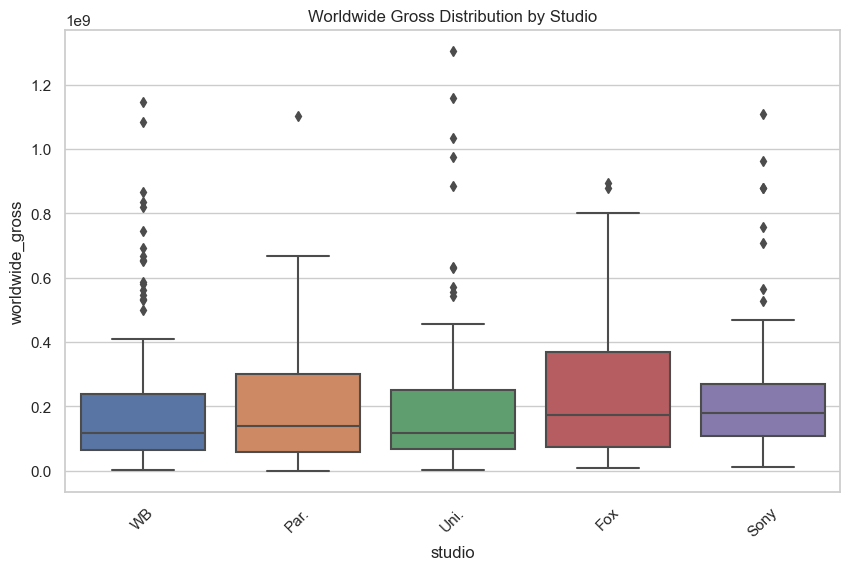

In [18]:
# Visualize the worldwide gross distribution by studio
plt.figure(figsize=(10, 6))
sns.boxplot(x='studio', y='worldwide_gross', data=gross_data[gross_data['studio'].isin(top_studios)])
plt.xticks(rotation=45)
plt.title('Worldwide Gross Distribution by Studio')
plt.show()

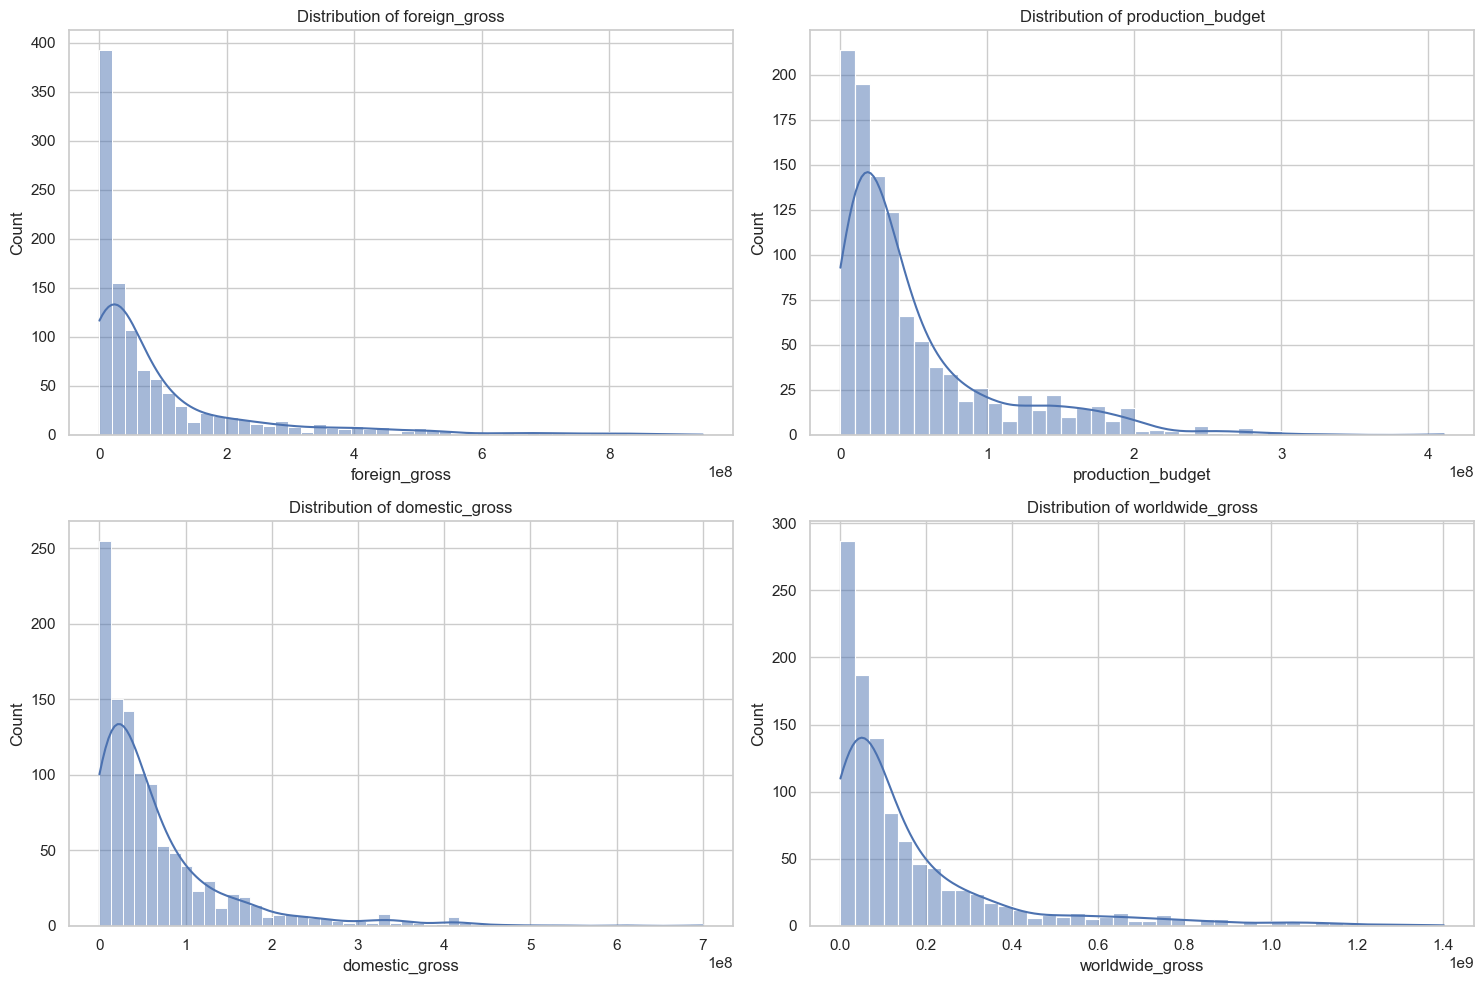

Best fitting distributions for each column:
foreign_gross: lognorm
production_budget: lognorm
domestic_gross: weibull_min
worldwide_gross: lognorm


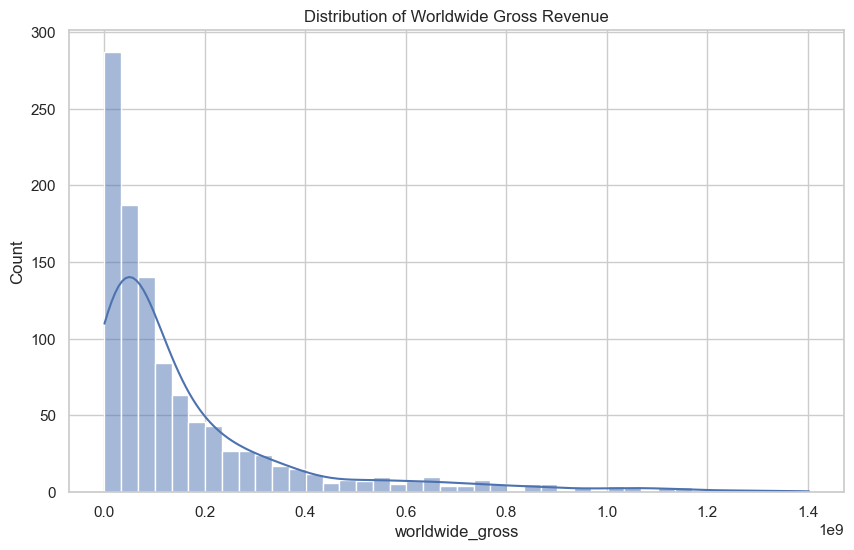

In [55]:
# Read the data
df = pd.read_csv('cleaned_gross_budget.csv')

# Let's look at the distributions of numerical columns
numerical_cols = ['foreign_gross', 'production_budget', 'domestic_gross', 'worldwide_gross']

# Create subplots for histograms and Q-Q plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Test different distributions
distributions = [
    stats.norm, stats.lognorm, stats.gamma, 
    stats.expon, stats.weibull_min
]

results = {}
for col in numerical_cols:
    data = df[col].dropna()
    best_dist = None
    best_ks_stat = np.inf
    
    for dist in distributions:
        # Fit distribution parameters
        params = dist.fit(data)
        # Perform Kolmogorov-Smirnov test
        ks_stat = stats.kstest(data, dist.name, params)[0]
        
        if ks_stat < best_ks_stat:
            best_ks_stat = ks_stat
            best_dist = dist.name
    
    results[col] = best_dist

print("\
Best fitting distributions for each column:")
for col, dist in results.items():
    print(f"{col}: {dist}")

# Let's visualize the best fit for worldwide_gross as an example
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='worldwide_gross', kde=True)
plt.title('Distribution of Worldwide Gross Revenue')
plt.show()

# Findings

## EDA

1. The Top five top watched movies are Drama, Comedy, Documentary, Thriller and Horror. 

2. The most porpular genre are Adventure, Animation, Action, Fantansy and Crime

3. The **Adventure** genre has a median rating of around 6. The IQR (middle 50% of ratings) stretches roughly from 5 to 7.5, suggesting that Adventure movies receive fairly moderate ratings, with most falling between 5 and 7.5. 

    **Fantasy** has a median rating of about 5.5, which is slightly lower than Adventure. The IQR spans from about 4.5 to 7, indicating more variability in ratings but still within a moderate range. This genre is more likely to have a wider spread in ratings.

## Statistical Distribution

4. This plot indicates that most movies tend to receive moderate ratings, with the majority scoring between 5 and 7. Very high (near 10) or very low (near 2) ratings are rare, which suggests that extreme responses to movies are uncommon in this dataset.

5. Z-test: Production budgets don't significantly differ from the $150M benchmark (p > 0.05)

6. T-test: There's a significant difference between domestic and foreign gross (p < 0.001)

7. ANOVA: No significant difference in worldwide gross among top 5 studios (p = 0.48)



# Conclusion 

1. Adventure and Fantasy genres receive moderate to high ratings, with most ratings falling between 5 and 7.5. Although they do not have the highest median ratings, they show a consistent pattern of audience engagement and satisfaction. This suggests that well-crafted movies in these genres are likely to perform well. The studio should consider these genres as core areas for content development, ensuring that production quality and storytelling meet high standards to capture and retain viewer interest.

2. Additionally, keeping production budgets around the industry standard of $150 million aligns well with current market trends, allowing the studio to maintain quality without overextending financially. With the domestic market showing stronger revenue potential, the studio could prioritize appealing to this audience initially, then expand to international markets as the brand grows. Lastly, as top studios do not significantly outperform each other in worldwide gross earnings, there is a viable opportunity for the new studio to compete effectively by focusing on quality and popular genres, creating a solid foundation in the box office.
